# Bright Block Data Processing Notebook


## Functions used for checking + testing data

In [444]:
%reset 
from datetime import datetime, timedelta
import numpy as np
import pandas as pd

def change_time_zone(uncorrected_time_zone_list, TimeZoneAdjustHours, yearsAdjustment):
    corrected_time_zone_list = []

    for timestamp in uncorrected_time_zone_list:
        # Parse the timestamp into a datetime object
        dt = datetime.strptime(timestamp, '%H:%M:%S %d/%m/%Y')
        # print(dt)

        # Adjust the time zone
        adjusted_dt = dt + timedelta(hours=TimeZoneAdjustHours)
        
        # Adjust the year
        adjusted_dt = adjusted_dt.replace(year=adjusted_dt.year + yearsAdjustment)

        # Convert back to the string format and add to the list
        corrected_time_zone_list.append(adjusted_dt.strftime('%H:%M:%S %d/%m/%Y'))

    return corrected_time_zone_list

def count_row_duplicates(df):
    # Create a temporary DataFrame indicating duplicated rows
    temp_df = df.copy()
    temp_df['IsDuplicated'] = df.duplicated(keep=False)

    # Group by all columns (excluding the 'IsDuplicated' column) and count duplicates
    duplicate_counts = temp_df.groupby(list(df.columns))['IsDuplicated'].sum()

    return duplicate_counts.reset_index(name='DuplicationCount').sort_values(by='TimeStamp', ascending=True)


## Big picture tasks for this dataset

Standardize Collection Graphs to capture the following:
 - Every graph needs to be automatically saved with Event #, Timestamp, should log which data collection/hardware setup I am using for different "data runs" (link that here maybe) 
 1. PM2.5 vs spacial Location, flagging any events I thought were high emmissions
 2. Pressure vs time Graph
 3. Presssure vs speed graph 
 4. Cost function comparaitive to Purple air?


### Arising Bugs
 1. What the fuck is up with this duplication???
 Behavior : Seeing data points which seem to be repeated up to 5X per data point [logginging severity in run metrics]
 
        a. Do I need to monitor battery? (Voltage dividor with  high enough resistance to not worry about power draw)
        b. Do I need to also have a seperate timer running on the device as to not pull only from the GPS

2. GPS Data does not perfectly map onto page (related to battery life?)

        a.  Mapbox has a plugin for this, look into this in more detail
        b. Check into other GPS modules (?) Plan to use phone longterm?
 

In [458]:
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point

FileNo = '46' 
file_path = 'RawData/Event' + FileNo + '.txt'
data = pd.read_csv(file_path, header=0)

data = data[(data['Latitude'] != 0) | (data['Longitude'] != 0)]
data = count_row_duplicates(data)

# Adjust timestamp
TimeZoneAdjust = -8
yearsAdjustment = 2000
data["TimeStampAdjusted"] = change_time_zone(data.TimeStamp, TimeZoneAdjust, yearsAdjustment) 
data["TimeStampHMS"] = data["TimeStampAdjusted"].str[0:8]

start_time = data["TimeStampAdjusted"][data.index.min()]

formatted_date = start_time[12:15] + start_time[9:11] + " " +start_time[0:5];  # '09:22:26 04/12/0023'
central_latitude = data.Latitude.mean()
central_longitude = data.Longitude.mean()
left_longitude = data.Longitude.min()
right_longitude =  data.Longitude.max()
longitude_span = right_longitude - left_longitude
top_latitude = data.Latitude.max()
bottom_latitude = data.Latitude.min()
latitude_span = top_latitude - bottom_latitude

auto_name = 'E' + FileNo + ": " +  formatted_date   
Pm2p5_Min = 0
Pm2p5_Max = data.PM25.min()
DataType = ["PM25"] #Temperature VO2

print(auto_name)



E46: 12/04 09:22


## [1] Plotting the physical PM2.5 Map 
FIXME: Still needs to have added logged events as needed

In [466]:
import folium
from branca.colormap import LinearColormap
from branca.element import Figure
from folium import IFrame, Marker


DataType = 'PM25'
# Define your custom color scale
colors = ["green", "yellow", "red"]


High_Threshold =  data[DataType].max() 
# print(High_Threshold)
Low_Threshold =data[DataType].min() #0


# Create a Folium map
colormap = LinearColormap(colors, vmin=Low_Threshold, vmax=High_Threshold)
m = folium.Map(location=[central_latitude, central_longitude],tiles="Cartodb Positron", zoom_start=25)
colormap.caption = DataType #+ formatted_date

# Prepare data for the line
line_data = [(row['Latitude'], row['Longitude']) for index, row in data.iterrows()]

# Normalize data values and get colors
normColorData = [colormap(min(max(row[DataType], Low_Threshold), High_Threshold)) for index, row in data.iterrows()]

# Plot the line
for i in range(len(line_data)-1):
    folium.PolyLine(line_data[i:i+2], color=normColorData[i], weight=5).add_to(m)
    if data.ButtonPress[i] != 0:
        Marker(location=[data.Latitude[i] , data.Longitude[i] ],  icon=folium.DivIcon(html=f"""
            <div><svg>
                <circle r ="20" fill="red", opacity=".3"/>
            </svg></div>""")).add_to(m)


# Add the colormap to the map
colormap.add_to(m)

# Create a Figure and add the map to it (for better control)
fig = Figure(width=800, height=500)
fig.add_child(m)

# Add the title HTML to the Folium map
iframe = IFrame(html=title_html, width=200, height=50)
popup = folium.Popup(iframe, max_width=500)
# FIXME: Make auto update distance 
Marker(location=[central_latitude + latitude_span/4, central_longitude - longitude_span/4], icon=folium.DivIcon(html=f"""
            <div style="
                background-color: white; 
                border: 1px solid black;
                padding: 10px;
                font-family: arial; 
                color: black;
                text-align: center;
                white-space: nowrap; /* Prevents text wrapping */
                width: auto; /* Adjust width as needed */
                display: inline-block; /* Ensure background covers text */
                ">
                {auto_name}
            </div>
            """)
).add_to(m)


# Display the map
m
    

## [2] Pressure vs Time Graph

In [461]:
DataType1 = ["PressurehPa"] #noxIndex Temperature # DataType2 = ["vocIndex"]
data.ButtonPress[0] = 1;

/var/folders/pv/0dy6d06n4396k5v_kmt15hkw0000gn/T/ipykernel_36732/1553198506.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.ButtonPress[0] = 1;


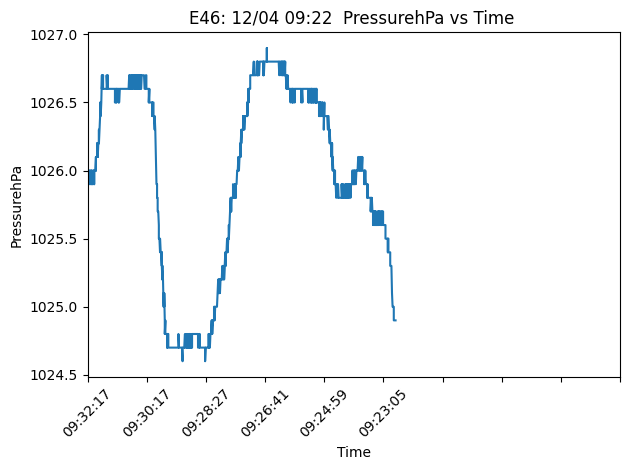

In [443]:

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Create a new figure and a subplot
fig, ax1 = plt.subplots()

# Plotting Pressure on the primary y-axis
color = 'tab:blue'
ax1.set_xlabel('Time')
ax1.set_ylabel(DataType1[0])
ax1.plot(data['TimeStampHMS'], data[DataType1], color=color)
ax1.tick_params(axis='y')

start_time = data["TimeStampAdjusted"][data.index.min()]
final_Index = np.size(data.TimeStampAdjusted)-1; 
end_time = data["TimeStampAdjusted"][final_Index]

# Rotate the date-time labels for better readability
plt.xticks(rotation=45)
ax1.set_xlim(start_time, end_time)
# ax1.set_xticks(np.arange(0, end_time , ))
count_ticks = 10
ax1.set_xticks(np.arange(0, len(data['TimeStampHMS']), len(data['TimeStampHMS'])/count_ticks ))
plt.title(auto_name + "  "+ DataType1[0] + " vs Time " )

# Show the plot
fig.tight_layout()
plt.show()


In [ ]:

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Create a new figure and a subplot
fig, ax1 = plt.subplots()

# Plotting Pressure on the primary y-axis
color = 'tab:blue'
ax1.set_xlabel('Time')
ax1.set_ylabel(DataType1[0])
ax1.plot(data['TimeStampAdjusted'], data[DataType1], color=color)
ax1.tick_params(axis='y')

# # Create a second y-axis for PM2.5
# ax2 = ax1.twinx()  
# color = 'tab:red'
# ax2.set_ylabel(DataType2, color=color)
# ax2.plot(data['TimeStampAdjusted'], data[DataType2], color=color)
# ax2.tick_params(axis='y', labelcolor=color)

# Format the date-time ticks
# start_time = data.TimeStamp[0][0:1] 

start_time = data["TimeStampAdjusted"][data.index.min()]
final_Index = np.size(data.TimeStampAdjusted)-1; 
end_time = data["TimeStampAdjusted"][final_Index]

# Rotate the date-time labels for better readability
# plt.xticks(rotation=45)
ax1.set_xlim(start_time, end_time)
# ax1.set_xlabel('')
# ax2.set_xlabel('')
ax1.set_xticks(np.arange(0, len(data.TimeStamp)/5, 500))
plt.title(auto_name + "  "+ DataType1[0] + " vs Time " )

# Show the plot
fig.tight_layout()
plt.show()


# Show the plot
fig.tight_layout()  # Adjusts the plot to fit into the figure area.
plt.show()



In [324]:
data['TimeStampHMS'][len(data['TimeStampHMS'])]

'09:31:31'

In [449]:
import pandas as pd
from datetime import datetime
from math import radians, cos, sin, sqrt, atan2

def haversine(lat1, lon1, lat2, lon2):
    """Calculate the great circle distance in kilometers between two points on the Earth."""
    R = 6371.0  # Radius of the Earth in kilometers

    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    distance = R * c
    return distance

def calculate_velocity(df):
    # Ensure the DataFrame is sorted by time
    df['TimeStampAdjusted'] = pd.to_datetime(df['TimeStampAdjusted'], format='%H:%M:%S %d/%m/%Y') #'09:22:26 04/12/0023'
    
    # print(df["TimeStampAdjusted"])
    df = df.sort_values('TimeStampAdjusted')

    # Calculate the distance and time difference
    distances = [0]
    times = [0]
    for i in range(1, len(df)):
        # Distance
        lat1, lon1 = df.iloc[i-1]['Latitude'], df.iloc[i-1]['Longitude']
        lat2, lon2 = df.iloc[i]['Latitude'], df.iloc[i]['Longitude']
        dist = haversine(lat1, lon1, lat2, lon2)
        distances.append(dist)

        # Time in hours
        
        time_diff = (df.iloc[i]['TimeStampAdjusted'] - df.iloc[i-1]['TimeStampAdjusted']).total_seconds() / 3600
        times.append(time_diff)

    # Calculate velocity (km/h)
    velocity = [dist/time if time != 0 else 0 for dist, time in zip(distances, times)]

    # Add velocity to the DataFrame
    df['velocity_km_h'] = velocity

    return df

# Example usage
# Assuming df is your DataFrame with 'latitude', 'longitude', and 'time' columns
df = data
df = calculate_velocity(df)
print(df)

               TimeStamp   Latitude  Longitude  Altitude    PM25  \
0    17:22:26 04/12/0023  37.758442 -122.42276      13.9  18.600   
1    17:22:27 04/12/0023  37.758369 -122.42265      13.9  18.500   
2    17:22:28 04/12/0023  37.758366 -122.42260      13.9  18.500   
3    17:22:29 04/12/0023  37.758301 -122.42250      14.1  18.600   
4    17:22:29 04/12/0023  37.758301 -122.42250      14.1  18.600   
..                   ...        ...        ...       ...     ...   
992  17:32:15 04/12/0023  37.764687 -122.39449      88.4  23.700   
993  17:32:15 04/12/0023  37.764687 -122.39449      88.4  23.799   
994  17:32:16 04/12/0023  37.764694 -122.39448      88.8  23.600   
995  17:32:16 04/12/0023  37.764694 -122.39448      88.8  23.700   
996  17:32:17 04/12/0023  37.764687 -122.39447      89.3  23.600   

     RelativeHumidity  Temperature  vocIndex  noxIndex  ButtonPress  \
0              61.180       20.030      58.0       1.0          0.0   
1              61.110       20.030      5

In [269]:
sampleString ='09:22:26 04/12/2023';
pd.to_datetime(sampleString, format='%H:%M:%S %d/%m/%Y')

# pd.to_datetime('2018-10-26 12:00:00.0000000011',
            #    format='%Y-%m-%d %H:%M:%S.%f')
# Timestamp('2018-10-26 12:00:00.000000001')

Timestamp('2023-12-04 09:22:26')

## Duplication Debug Code 

Two Plots showing Duplication in the dataset

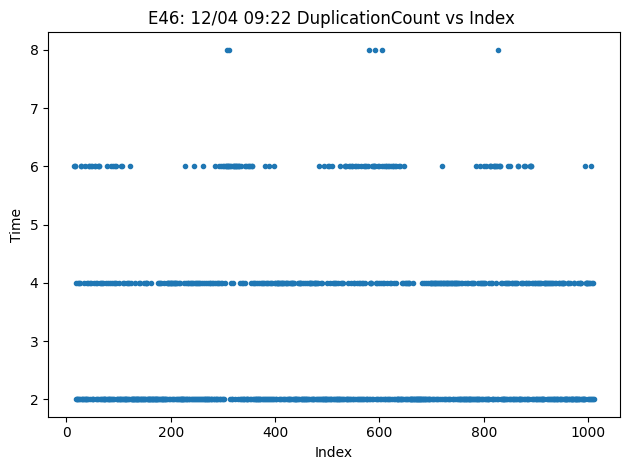

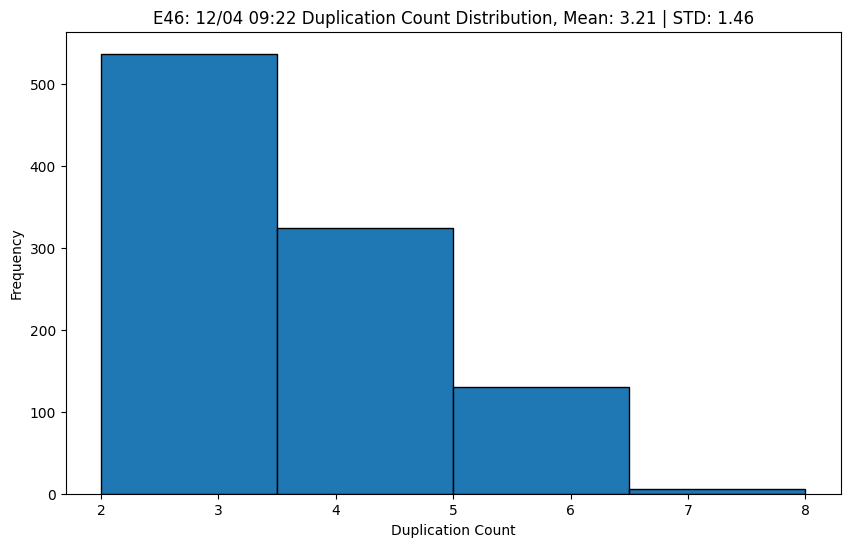

In [381]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Create a new figure and a subplot
fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('Index')
ax1.set_ylabel('Time')
ax1.plot(data['DuplicationCount'],'.' , color=color)
ax1.tick_params(axis='y')

start_time = data["TimeStampAdjusted"][data.index.min()]
final_Index = np.size(data.TimeStampAdjusted)-1; 
end_time = data["TimeStampAdjusted"][final_Index]

count_ticks = 10
plt.title(auto_name + " DuplicationCount vs Index ")

# Show the plot
fig.tight_layout()
plt.show()

# Create a new figure for the histogram
plt.figure(figsize=(10, 6))

# Plot the histogram
plt.hist(data['DuplicationCount'], bins=4, color='tab:blue', edgecolor='black')

Duplication_STD = np.std(data['DuplicationCount'])
Duplication_Mean = np.mean(data['DuplicationCount'])

# Set the title and labels
plt.title(auto_name + " Duplication Count Distribution, Mean: " + '{:.2f}'.format(Duplication_Mean) + " | STD: " + '{:.2f}'.format(Duplication_STD) )
plt.xlabel('Duplication Count')
plt.ylabel('Frequency')

# Show the plot
plt.show()
